### Apply the reaction classification model for recovering unclassified reactions from the patent data

In [1]:
import _pickle as cPickle
import gzip
from collections import defaultdict
import random
from sklearn.linear_model import LogisticRegression
import utilsFunctions
# from sklearn.externals import joblib
import joblib
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from rdkit.Chem import PandasTools
from base64 import b64encode
import types
# from rdkit.six.moves import cStringIO as StringIO
from io import StringIO
from IPython.display import display,IFrame
# from IPython.display import display,HTML
import numpy as np
from pylab import rcParams

In [57]:
from rdkit import rdBase
rdBase.rdkitVersion

'2020.09.1'

Choose some larger text size in the plots

In [2]:
rcParams.update({'font.size': 14})

Some functions for drawing the reactions

In [3]:
def removeMappingNumbersFromSmiles(smi):
    new_smi=''
    i=0
    while i < len(smi):
        if smi[i] == ':':     
            i += 1
            j = i
            while smi[j] != ']':
                if smi[j].isdigit():
                    i+=1

                j+=1
            new_smi += smi[i]
            i+= 1
            continue
        else:
            new_smi += smi[i]
        i += 1
    return new_smi

def reactionToHTMLImage(rxn):
    x = Draw.ReactionToImage(rxn)
    """displayhook function for PIL Images, rendered as PNG"""
    sio = StringIO()
    x.save(sio,format='PNG')
    s = b64encode(sio.getvalue())
    pd.set_option('display.max_columns',len(s)+1000)
    pd.set_option('display.max_rows',len(s)+1000)
    pd.set_option("display.max_colwidth",len(s)+10000000000)
    return '<img src="data:image/png;base64,%s" alt="Mol"/>'%s

Chem.rdChemReactions.ChemicalReaction.__str__=reactionToHTMLImage

def AddReactionColumnToFrame(frame, smilesCol='smi', reactCol = 'Reaction'):
    frame[reactCol]=frame.apply(lambda x: AllChem.ReactionFromSmarts(x[smilesCol], useSmiles=True), axis=1)
    PandasTools.RenderImagesInAllDataFrames(images=True)
    
def AddReactionColumnToFrame2(frame, smilesCol='smi', reactCol = 'Reaction'):
    
    smilestr = frame[smilesCol]
#     frame[reactCol] = frame['classname']
    for i, each_smil in enumerate(smilestr):
        rxn = AllChem.ReactionFromSmarts(each_smil, useSmiles=True)
        d2d = Draw.MolDraw2DCairo(800,300)
        d2d.DrawReaction(rxn)
        png = d2d.GetDrawingText()
        filename = './images/reaction'+str(i)+'.png'
        open(filename,'wb+').write(png)
#         frame[reactCol][i] = filename
#     frame[reactCol]=frame.apply(lambda x: AllChem.ReactionFromSmarts(x[smilesCol], useSmiles=True), axis=1)
#     PandasTools.RenderImagesInAllDataFrames(images=True)

In [4]:
dataDir = "../data/"

with open(dataDir+"reactionTypes_training_test_set_patent_data.pkl",'rb') as f:
    reaction_types = cPickle.load(f)
with open(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl",'rb') as f:
    names_rTypes = cPickle.load(f)

# reaction_types = cPickle.load(file(dataDir+"reactionTypes_training_test_set_patent_data.pkl"))
# names_rTypes = cPickle.load(file(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl"))

Load the AP3 and agent feature fingerprint for the 50000 unclassified reactions

In [5]:
infile = gzip.open(dataDir+"transformationFPs_agentFPs_external_test_set_B.pkl.gz", 'rb')

lineNo=0
fps=[]
smis=[]

fpsz=256
while 1:
    lineNo+=1
    try:
        lbl,smi,apfp_woA,agent_feature = cPickle.load(infile)        
    except EOFError:
        break
    np1 = utilsFunctions.fpToNPfloat(apfp_woA,fpsz)
    np2 = np.asarray(agent_feature, dtype=float)
    smis.append((smi, lbl))
    fps += [np.concatenate([np1, np2])]
    if not lineNo%10000:
        print("Done "+str(lineNo))

Done 10000
Done 20000
Done 30000
Done 40000


In [6]:
print(lineNo)

49845


Load the reaction type, reaction class and super-class model

In [7]:
clf = joblib.load(dataDir+'LR_transformationFP256bit.AP3.agent_featureFP.pkl')
clf1 = joblib.load(dataDir+'LR_transformationFP256bit.AP3.agent_featureFP_classModel.pkl')
clf2 = joblib.load(dataDir+'LR_transformationFP256bit.AP3.agent_featureFP_superclassModel.pkl')

Predict the reaction types of the unclassified reactions and plot the distribution of the 50 reaction types

Text(0.5, 1.0, 'Reaction type prediction')

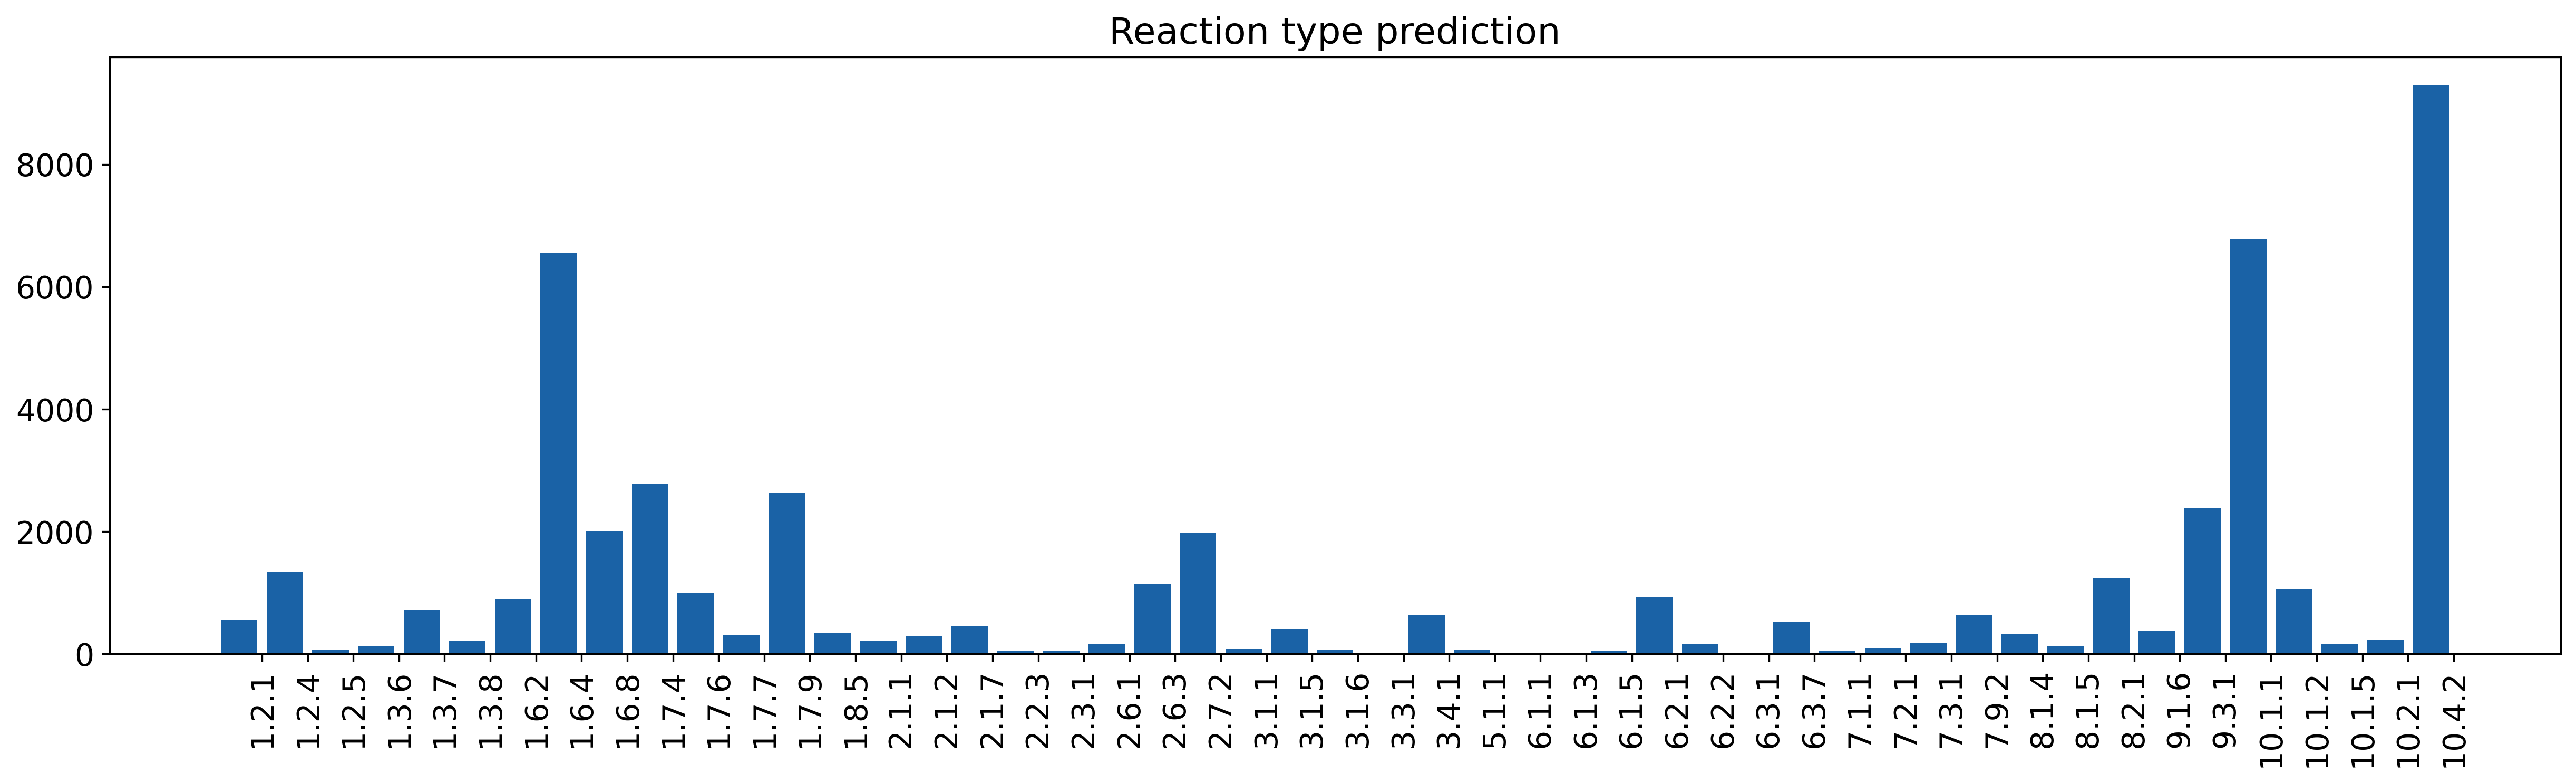

In [8]:
import matplotlib.pyplot as plt

rtypes = sorted(list(reaction_types))
preds = clf.predict(fps)
preds_proba = clf.predict_proba(fps)
newPreds=[rtypes[x] for x in preds]
preds2 = defaultdict(int)
for i in newPreds:
    preds2[i]+=1
preds2_sorted = sorted(preds2.items(), key=lambda x:(int(x[0].split('.')[0]), int(x[0].split('.')[1]), int(x[0].split('.')[2])))    
labels = [x[0] for x in preds2_sorted]
values = [x[1] for x in preds2_sorted]
ind = np.arange(len(values))

plt.figure(1,figsize=(20,5),dpi=300)
plt.subplot(1,1,1)    
plt.bar(ind, values,color="#1a62a6")
plt.xticks(np.arange(len(labels))+.5,labels,rotation='vertical')
plt.title('Reaction type prediction')

Select the most likely reaction type per reaction

In [9]:
probs = [(rtypes[x.argmax()], names_rTypes[rtypes[x.argmax()]], x.max()) for x in preds_proba]

Only keep those with a high probability (>95%) for one of the 50 reaction types. Plot the distribution of the remaining reactions again.

47737


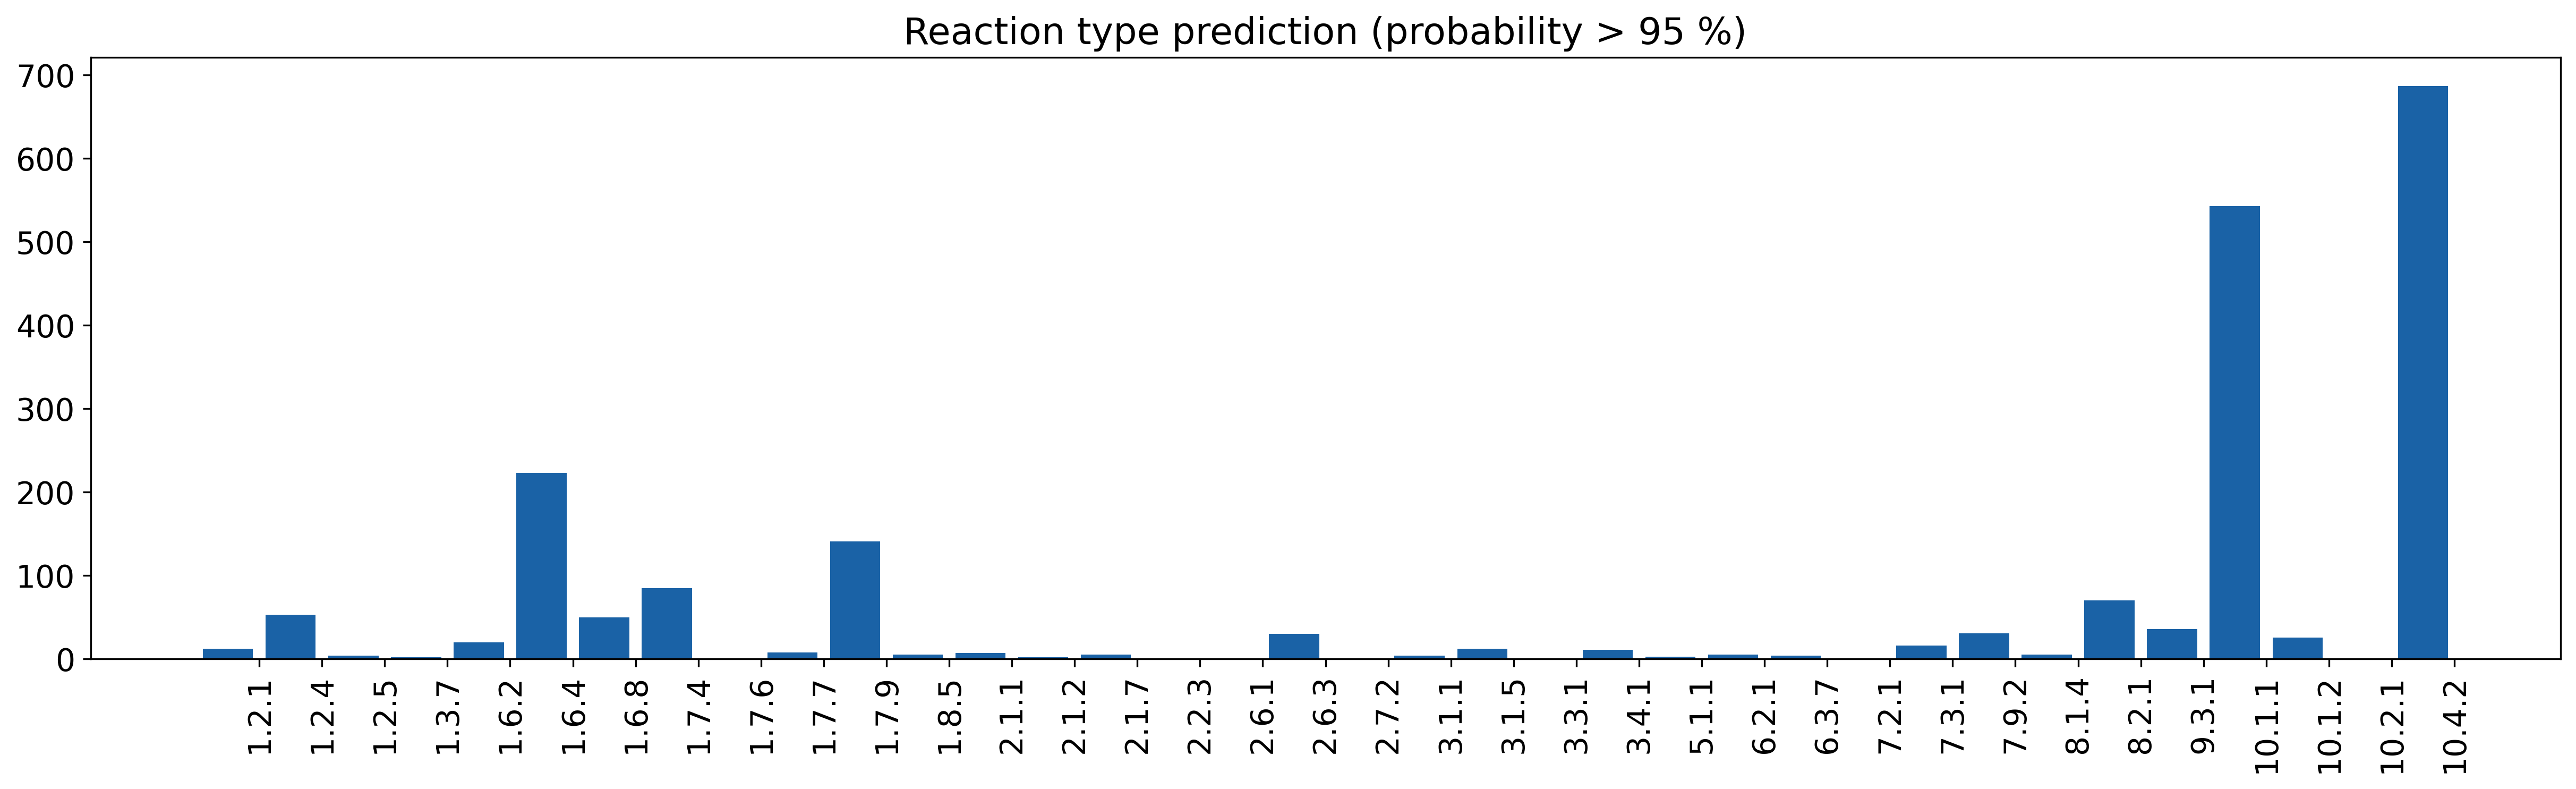

In [10]:
count = 0
preds = defaultdict(int)
best_reactions={}
for n,i in enumerate(probs):
    if i[2] > 0.95:
        preds[i[0]]+=1
        if i[0] in best_reactions:
            best_reactions[i[0]].append((i[2],n,i[0],i[1]))
        else:
            best_reactions[i[0]]=[(i[2],n,i[0],i[1])]
    else:
        count+=1

preds_sorted = sorted(preds.items(), key=lambda x:(int(x[0].split('.')[0]), int(x[0].split('.')[1]), int(x[0].split('.')[2])))    
labels = [x[0] for x in preds_sorted]
values = [x[1] for x in preds_sorted]
ind = np.arange(len(values))
maxi = np.array(values).max()

plt.figure(1,figsize=(20,5),dpi=300)
plt.subplot(1,1,1)    
plt.bar(ind, values,color="#1a62a6")
plt.xticks(np.arange(len(labels))+.5,labels,rotation='vertical')
plt.title('Reaction type prediction (probability > 95 %)')
print(count)

Look at the number of different reaction types found in the unclassified reactions

In [11]:
len(best_reactions)

36

Build lists of reaction classes and super-classes

In [12]:
reaction_classes = sorted(list(set(x.split('.')[0]+"."+x.split('.')[1] for x in reaction_types)))
print(reaction_classes)
reaction_superclasses = sorted(list(set(x.split('.')[0] for x in reaction_types)))
print(reaction_superclasses)

['1.2', '1.3', '1.6', '1.7', '1.8', '10.1', '10.2', '10.4', '2.1', '2.2', '2.3', '2.6', '2.7', '3.1', '3.3', '3.4', '5.1', '6.1', '6.2', '6.3', '7.1', '7.2', '7.3', '7.9', '8.1', '8.2', '9.1', '9.3']
['1', '10', '2', '3', '5', '6', '7', '8', '9']


Build a new subset of the 1414 remaining reactions

In [13]:
newTestSubsets = defaultdict(list)
idxdict = defaultdict(list)
for i in best_reactions.keys():
    for n,j in enumerate(best_reactions[i]):
        idx = j[1]
        idxdict[i].append(idx)
        newTestSubsets[i].append(fps[idx])

Classify this subset using the reaction class and super-class predictive model

In [14]:
res=defaultdict(list)
for i in newTestSubsets.keys():
    for n,fp in enumerate(newTestSubsets[i]):
        idxFP = idxdict[i][n]
        type_prob = best_reactions[i][n][0]
#         print(fp)
#         print(clf1.predict_proba(fp.reshape(1, -1)))
        cls = reaction_classes[np.array(clf1.predict_proba(fp.reshape(1, -1))).argmax()]
        cls_prob = np.array(clf1.predict_proba(fp.reshape(1, -1))).max()
        scls = reaction_superclasses[np.array(clf2.predict_proba(fp.reshape(1, -1))).argmax()]
        scls_prob = np.array(clf2.predict_proba(fp.reshape(1, -1))).max()
        res[i].append([idxFP, type_prob, cls, cls_prob, scls, scls_prob])

Confirm a consistent reaction type, class and super-class. Additionally, calculate the mean probability of reaction type, class and superclass for each of the reactions.

In [15]:
best_res = defaultdict(list)
remaining_reactions=0
for i in res.keys():
    for j in res[i]:
        if j[2] == i.split('.')[0]+'.'+i.split('.')[1] and j[4] == i.split('.')[0]:
            mean_prob = (j[1]+j[3]+j[5])/3.0
            best_res[i].append([mean_prob, j])
            remaining_reactions+=1
print(remaining_reactions)
print(len(best_res.keys()))

263
8


Sort the remaining reactions by their mean probability in descending order. Only keep the best 5 per class and ignore duplicates (same probability).

In [16]:
import operator
res_to_classify=defaultdict(list)
numclassify=0
for i in best_res.keys():
    subset = sorted(best_res[i], key=operator.itemgetter(0), reverse=True)
    prob_before = 10
    counter = 0
    for s in subset:
        prob_cur = s[0]
        if prob_cur != prob_before and counter < 5:
            res_to_classify[i].append(s)
            counter+=1
            numclassify+=1
        prob_before=prob_cur
print(numclassify)

30


Prepare the reactions for storing in a Pandas table

In [17]:
reacts_to_draw=[]
for i in res_to_classify.keys():
    for j in res_to_classify[i]:
        rtype = i
        mean_prob = j[0]
        smi = smis[j[1][0]][0]
        idx = smis[j[1][0]][1]
        #rxn = AllChem.ReactionFromSmarts(smi, useSmiles=True)
        #rxn.RemoveUnmappedReactantTemplates()
        #smi = AllChem.ReactionToSmiles(rxn)
        smi = removeMappingNumbersFromSmiles(smi)
        typename = probs[j[1][0]][1]
        reacts_to_draw.append((rtype, typename, mean_prob,smi,idx))
        
# print(reacts_to_draw)

Add the reaction and depictions of them to a Pandas table

In [18]:
data = pd.DataFrame(reacts_to_draw, columns=['class', 'classname', 'prob','smi','patent'])
AddReactionColumnToFrame2(data, smilesCol='smi', reactCol = 'Reaction')
# data = data.drop('smi',1)


# data.iloc[1]
# data.shape
# data.info()

display(data)

# print(data)
## display errors

,class,classname,prob,smi,patent
0,10.1.1,Bromination,0.799450,[K+].[K+].[CH3][C](=[O])[N]1[CH2][CH2][CH]([C]...,04670447
1,10.1.1,Bromination,0.771291,O.[K+].[K+].[CH3][C](=[O])[N]1[CH2][CH2][CH]([...,04933460
2,10.1.1,Bromination,0.762669,[H-].[NH4+].[OH-].[Na+].[CH3][c]1[n][c]2[n]([c...,04957916
3,10.1.1,Bromination,0.726115,[Li][CH3].[CH3][C]1([CH3])[CH2][CH2][C]([CH3])...,05476860
4,10.1.1,Bromination,0.696026,[Mg].Cl.[CH3][I].[O]=[CH][c]1[cH][n][n]2[c]1[n...,04281000
5,10.4.2,Methylation,0.990364,[Na+].Cl.[K+].[I-].O=C([O-])O.[O]=[c]1[cH][c](...,US06187793
6,10.4.2,Methylation,0.988776,[K+].[K+].CN(C)C=O.O=C([O-])[O-].[O]=[c]1[nH][...,04608375
7,10.4.2,Methylation,0.987428,[K+].[K+].CO.C[O][C](=[O])[CH2][CH2][CH2][CH2]...,05767285
8,10.4.2,Methylation,0.985223,[Na+].[Na+].[Na+].[I-].CCN(C(C)C)C(C)C.O=C([O-...,04891375
9,10.4.2,Methylation,0.984905,[Na+].[Na+].CC(=O)CC(C)C.O=C([O-])[O-].[O]=[c]...,04066772


Display the results in a Pandas table

In [54]:
# result = data.to_html(notebook=True)
# display()